### *HELPFUL LINKS*

##### (1). https://avandekleut.github.io/vae/
##### (2). https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

In [1]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
from time import time
import torch
import torchvision
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import distributions

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### *DATA IMPORTS*

In [3]:
data = pd.read_csv('C:\\Users\\Ayush\\Desktop\\ML PROJECTS\\digit-recognizer\\data\\train.csv').iloc[:,1:].values
data = torch.tensor(data)
data.shape

torch.Size([42000, 784])

In [4]:
train_loader = DataLoader(data,batch_size=128,shuffle=False)

In [5]:
print(next(iter(train_loader)).shape)
next(iter(train_loader))

torch.Size([128, 784])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [6]:
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,:]
    plt.imshow(temp.reshape(28,28))
    plt.title(batch[i,0].item())
    plt.axis('off')

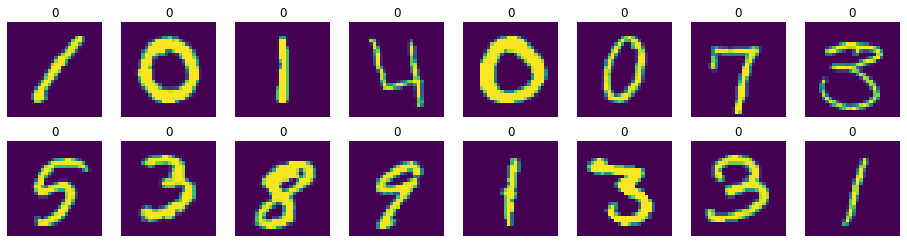

In [7]:
PlotBatch(train_loader,batch_size=128)

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.relu = nn.ReLU().to(device)
        self.linear1 = nn.Linear(784,512).to(device)
        self.linear2 = nn.Linear(512,2).to(device) # this term is for calculating mu
        self.linear3 = nn.Linear(512,2).to(device) # this term is for calculating sigma
        self.dist = distributions.Normal(0,1)
        '''we will sample vectors of latent space by renormalizing the sample vector of the normal 
        gaussian deistribution by mean and variance of data examples' distribution ''' 
        self.kl = 0  
        '''kl divergence loss term is fir two purposes, first it will allow gradients to flow
        and secondly we need our distribution to be as close to N(0,1)'''
        
        
        
    def forward(self,x):
        op = self.relu(self.linear1(x))
        mu = self.linear2(op)
        sigma = torch.exp(self.linear3(op)) 
        sample = self.dist.sample(mu.shape).to(device)
        z = mu + sigma*sample
        self.kl = (mu**2 + sigma**2 - torch.log(sigma) -1/2).sum()
        return z,mu,sigma
        

In [9]:
model_encoder = Encoder().to(device)
summary(model_encoder,(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                    [-1, 2]           1,026
            Linear-4                    [-1, 2]           1,026
Total params: 403,972
Trainable params: 403,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.54
Estimated Total Size (MB): 1.55
----------------------------------------------------------------


In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2,512),
            nn.ReLU(),
            nn.Linear(512,784),
            nn.Sigmoid()
        ).to(device)
        
    def forward(self,x):
        op = self.model(x)
        return op

In [11]:
model_decoder = Decoder().to(device)
summary(model_decoder,(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           1,536
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 784]         402,192
           Sigmoid-4                  [-1, 784]               0
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.54
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        
        
    def forward(self,x):
        op,mu,sigma = self.encoder(x)
        op = self.decoder(op)
        return op,mu,sigma

In [13]:
model_autoencoder = Autoencoder().to(device)
summary(model_autoencoder,(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                    [-1, 2]           1,026
            Linear-4                    [-1, 2]           1,026
           Encoder-5  [[-1, 2], [-1, 2], [-1, 2]]               0
            Linear-6                  [-1, 512]           1,536
              ReLU-7                  [-1, 512]               0
            Linear-8                  [-1, 784]         402,192
           Sigmoid-9                  [-1, 784]               0
          Decoder-10                  [-1, 784]               0
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.08
Estimated

In [14]:
batch_size = 128
epochs = 20
lr = 1e-3
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=lr)

In [15]:
def train(epochs):
    losses = []
    for epoch in range(1,epochs+1):
        tic = time()
        LOSS = 0
        for i,batch in enumerate(train_loader,1):
            # forward propoagation
            loss = 0
            model_input = (batch/255.0).to(device)
            optimizer.zero_grad()
            model_output, _ , _ = autoencoder(model_input)
            loss = ((model_output - model_input)**2).sum() + autoencoder.encoder.kl
            LOSS+= loss.item()
            # backward propoagtaion
            loss.backward()
            optimizer.step()
            
            if i%100==0:
                print('Epoch [{}] ({}/{}), train_loss = {:.4f}'.format(epoch, i, len(train_loader), loss.item()))
        print("\nTime taken:",time()-tic,"sec\n")
        losses.append(LOSS/batch_size)
    return losses        

In [16]:
tic = time()
losses= train(epochs)
print("Total time taken:",time()-tic,"sec")

Epoch [1] (100/329), train_loss = 6341.5288
Epoch [1] (200/329), train_loss = 5965.4268
Epoch [1] (300/329), train_loss = 5900.3125

Time taken: 6.021293640136719 sec

Epoch [2] (100/329), train_loss = 5762.3647
Epoch [2] (200/329), train_loss = 5578.8599
Epoch [2] (300/329), train_loss = 5676.8569

Time taken: 6.029980897903442 sec

Epoch [3] (100/329), train_loss = 5639.9062
Epoch [3] (200/329), train_loss = 5494.5581
Epoch [3] (300/329), train_loss = 5616.1128

Time taken: 5.912757873535156 sec

Epoch [4] (100/329), train_loss = 5554.9131
Epoch [4] (200/329), train_loss = 5390.3799
Epoch [4] (300/329), train_loss = 5524.1523

Time taken: 6.046961784362793 sec

Epoch [5] (100/329), train_loss = 5481.0830
Epoch [5] (200/329), train_loss = 5308.3315
Epoch [5] (300/329), train_loss = 5476.3174

Time taken: 5.997494220733643 sec

Epoch [6] (100/329), train_loss = 5406.0708
Epoch [6] (200/329), train_loss = 5287.9307
Epoch [6] (300/329), train_loss = 5433.8804

Time taken: 5.9793460369110

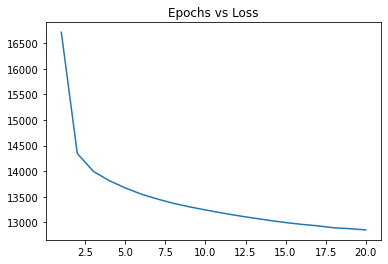

In [17]:
plt.plot(range(1,epochs+1),losses)
plt.title("Epochs vs Loss")
plt.show()

### *TESTING OF THE MODEL*

In [18]:
def GenImg():
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    noise = distributions.Normal(0,1).sample((1,2)).to(device)
    image = autoencoder.decoder(noise).reshape(28,28)
    image = image.cpu().detach().numpy()

    plt.imshow(image)
    plt.axis('off')

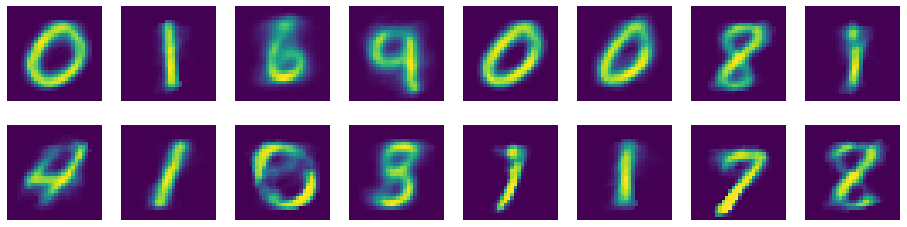

In [19]:
GenImg()

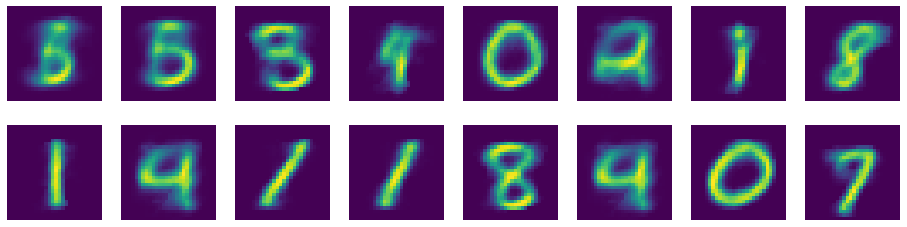

In [20]:
GenImg()

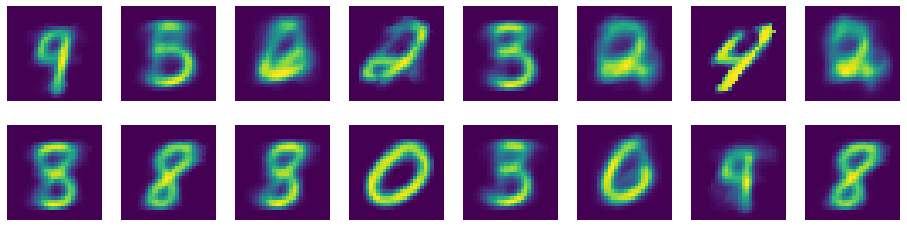

In [21]:
GenImg()

### *LETS TRY OUT A CONVOLUTIONAL VAE*

In [33]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super(ConvEncoder,self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=4,out_channels=8,kernel_size=3,stride=1,padding=1)
        self.linear1 = nn.Linear(8*7*7,128)
        self.linear2 = nn.Linear(128,2)
        self.dist = torch.distributions.Normal(0,1)
        self.kl = 0
        
    def forward(self,x):
        x = x.reshape(-1,1,28,28)
        op = self.pool(self.relu(self.conv1(x)))
        op = self.pool(self.relu(self.conv2(op)))
        op = op.reshape(-1,8*7*7)
        op = self.relu(self.linear1(op))
        mu = self.linear2(op)
        sigma = torch.exp(self.linear2(op))
        # sampling 
        sample = self.dist.sample(mu.shape).to(device)
        z = mu+sigma*sample
        self.kl = (mu**2+sigma**2-torch.log(sigma)-1/2).sum()
        return z
        

In [34]:
class ConvDecoder(nn.Module):
    def __init__(self):
        super(ConvDecoder,self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear1 = nn.Linear(2,128)
        self.linear2 = nn.Linear(128,392)
        self.conv_t_1 = nn.ConvTranspose2d(in_channels=8,out_channels=4,kernel_size=2,stride=2,padding=0)
        self.conv_t_2 = nn.ConvTranspose2d(in_channels=4,out_channels=1,kernel_size=2,stride=2,padding=0)
        
        
        
    def forward(self,x):
        op = self.relu(self.linear1(x))
        op = self.relu(self.linear2(op))
        op = op.reshape(-1,8,7,7)
        op = self.relu(self.conv_t_1(op))
        op = self.sigmoid(self.conv_t_2(op))
        op = op.reshape(-1,784)
        return op

In [35]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder,self).__init__()
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()
        
    def forward(self,x):
        op = self.encoder(x)
        op = self.decoder(op)
        return op

In [36]:
batch_size = 128
epochs = 20
lr = 1e-3
conv_autoencoder = ConvAutoencoder().to(device)
optimizer = torch.optim.Adam(conv_autoencoder.parameters(),lr=lr)

In [37]:
def train_conv(epochs):
    losses = []
    for epoch in range(1,epochs+1):
        tic = time()
        LOSS = 0
        for i,batch in enumerate(train_loader,1):
            # forward propoagation
            loss = 0
            model_input = (batch/255.0).to(device)
            optimizer.zero_grad()
            model_output = conv_autoencoder(model_input)
            loss = ((model_output - model_input)**2).sum() + conv_autoencoder.encoder.kl
            LOSS+= loss.item()
            # backward propoagtaion
            loss.backward()
            optimizer.step()
            
            if i%100==0:
                print('Epoch [{}] ({}/{}), train_loss = {:.4f}'.format(epoch, i, len(train_loader), loss.item()))
        print("\nTime taken:",time()-tic,"sec\n")
        losses.append(LOSS/batch_size)
    return losses        

In [38]:
tic = time()
losses_conv= train_conv(epochs)
print("Total time taken:",time()-tic,"sec")

Epoch [1] (100/329), train_loss = 11521.4209
Epoch [1] (200/329), train_loss = 7327.3257
Epoch [1] (300/329), train_loss = 7244.3789

Time taken: 10.29017162322998 sec

Epoch [2] (100/329), train_loss = 6931.8022
Epoch [2] (200/329), train_loss = 6823.0298
Epoch [2] (300/329), train_loss = 6929.6577

Time taken: 10.444157361984253 sec

Epoch [3] (100/329), train_loss = 6792.2588
Epoch [3] (200/329), train_loss = 6705.7280
Epoch [3] (300/329), train_loss = 6920.6382

Time taken: 10.320683479309082 sec

Epoch [4] (100/329), train_loss = 6688.7090
Epoch [4] (200/329), train_loss = 6734.3716
Epoch [4] (300/329), train_loss = 6955.6050

Time taken: 10.186432123184204 sec

Epoch [5] (100/329), train_loss = 6675.1060
Epoch [5] (200/329), train_loss = 6702.9912
Epoch [5] (300/329), train_loss = 6937.2241

Time taken: 10.368708848953247 sec

Epoch [6] (100/329), train_loss = 6709.0400
Epoch [6] (200/329), train_loss = 6669.2290
Epoch [6] (300/329), train_loss = 6841.1797

Time taken: 10.2028808

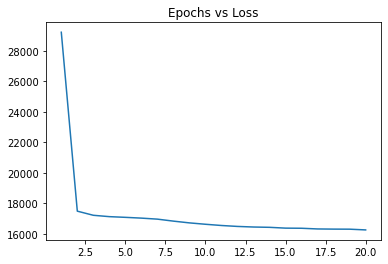

In [39]:
plt.plot(range(1,epochs+1),losses_conv)
plt.title("Epochs vs Loss")
plt.show()

In [40]:
def GenImgConv():
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    noise = distributions.Normal(0,1).sample((1,2)).to(device)
    image = conv_autoencoder.decoder(noise).reshape(28,28)
    image = image.cpu().detach().numpy()

    plt.imshow(image)
    plt.axis('off')

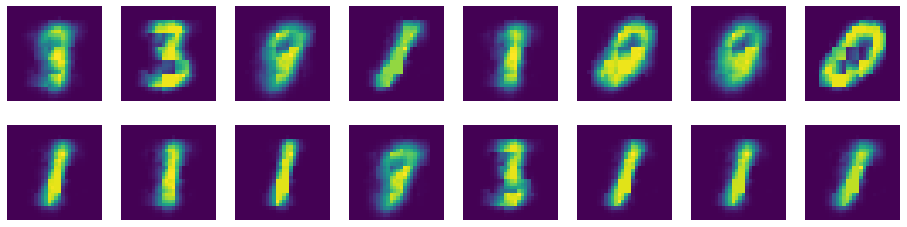

In [41]:
GenImgConv()

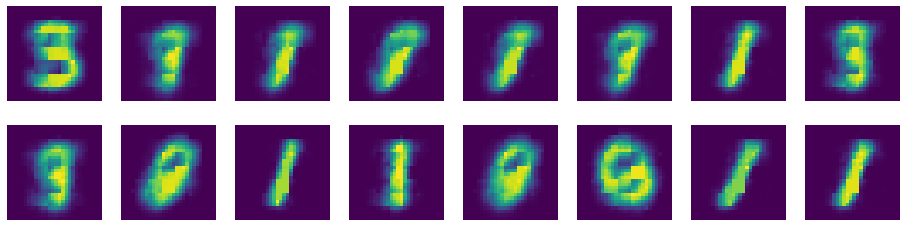

In [42]:
GenImgConv()

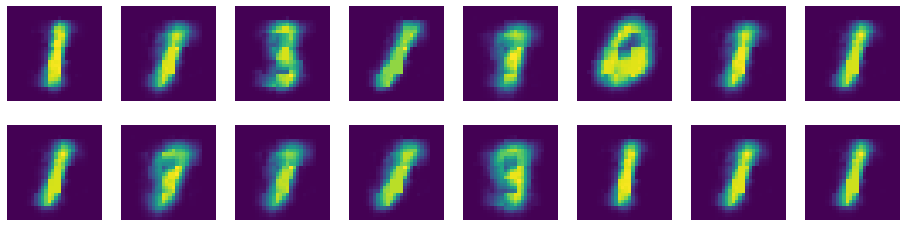

In [43]:
GenImgConv()

### *LINEAR LAYERS ARE PERFORMING WELL*